In [5]:
from Bio import AlignIO
import numpy as np
import pandas as pd
from collections import defaultdict

In [9]:
alignfile = '../../data/main/h24_linsi.fasta'
align = AlignIO.read(alignfile, 'fasta')
align = np.array([list(rec) for rec in align], np.character, order="F") # Read in alignment, make a dataframe
nsites = len(align.T)
nseqs = len(align)
align = pd.DataFrame(align, columns=range(nsites), index=range(nseqs)) # Use pandas indexing to keep site numbers in tact

In [2]:
nt = ['a', 'c', 't', 'g', 'A', 'C', 'T', 'G'] # Allowed nucleotide characters

def get_majorminor(site):
    site = site[site.isin(nt)]           # Remove the gaps and other invalid characters
    counts = site.value_counts()
    total = float(counts.sum())
    if total < 20 or len(counts) < 2: # If not polymorphic, invalid.
        return np.nan                   # If < 10 characters left, invalid.
    counts = counts[ counts/total >= 0.01] # Remove rare variants
    if len(counts) == 2:
        return tuple(counts.index)    # If that leaves us with two alleles (major and minor), return just the alleles
    else:
        return np.nan                   # Otherwise, the site is not biallelic; return None.

In [3]:
print 'finding major/minor alleles'
majorminor = align.apply(lambda x: get_majorminor(x)) # Get the (major,minor) alleles for each site if possible
majorminor.dropna(inplace=True) # Drop the non-biallelic sites
validsites = majorminor.index.values # Valid sites are the biallelic ones
results = pd.DataFrame(columns=validsites, index=validsites, dtype='float') # Store results

print 'found %d valid sites'%len(validsites)
print 'starting comparisons'

finding major/minor alleles
found 1526 valid sites
starting comparisons


In [4]:
def r_squared(haplotypes):
    hapObs = pd.Series(haplotypes).value_counts() # Tally observed counts of haplotypes and alleles
    if len(haplotypes) < 20: # Check, yet again, that we have enough data for this site
        return np.nan
    else:
        pass
    
    allele_i_obs = pd.Series([ h[0] for h in haplotypes]).value_counts()
    allele_j_obs = pd.Series([ h[1] for h in haplotypes ]).value_counts()
    
    if len(allele_i_obs) != 2 or len(allele_j_obs) != 2: # Check again that we have two alleles per site
        return np.nan
    else:
        pass
    

    hapExp = {}

    N = float(hapObs.sum()) # Total N of observed haplotypes
    
    for i in allele_i_obs.index.values:
        for j in allele_j_obs.index.values:
            # Exp counts = row (allele0|site0) total*column (allele1|site1) total / table (allele) total
            hapExp[i+j]=(float(allele_i_obs[i])*float(allele_j_obs[j]))/N # If this haplotype is never observed, use 0
            
    chisq = 0.0
    for hap in hapExp.keys(): # Calculate chi-squared
                              # chisq = sum( (E-O)**2/E for each possible haplotype )
        if hap in hapObs:     # deal with unobserved haplotypes
            chisq += ((float(hapObs[hap]) - hapExp[hap])**2)/hapExp[hap] 
        else:
            chisq += ((0.0 - hapExp[hap])**2)/hapExp[hap] 
    
    r_sq = chisq / (N)  # r^2 = chisq / (Nsamples * df) ; because all sites biallelic, df == (2-1)(2-1) == 1
#     if r_sq > 1:
#         print haplotypes
#         print hapObs
#         print allele_i_obs
#         print allele_j_obs
#         print hapExp
#         print r_sq
    return r_sq
print 'ready'

ready


In [5]:
for x in range(len(validsites)): # Make upper-triangle comparisons
    i = validsites[x]
    column_i = align.loc[:,i] # Pull the alignment column
    alleles_i = majorminor.loc[i] # And the (major,minor) alleles we found earlier
    
    for y in range(x+1, len(validsites)):
        j = validsites[y]
        column_j = align[j]
        alleles_j = majorminor.loc[j] # Make a list of all the observed haplotypes that consist of the major or minor allele for each site

        haplotypes = [ (h[0]+h[1]).upper() for h in zip(column_i, column_j) if h[0] in alleles_i and h[1] in alleles_j]

        if len(haplotypes) < 10: # Do we still have enough data? 
            continue
        else:
            results.at[i,j] = r_squared(haplotypes) # Save results in the df
print 'done'

done


In [6]:
results.dropna(axis=(0,1), how='all', inplace=True) # Drop any sites where we didn't have enough information to calculate chisqdf
results.to_csv('r_squared_out.csv')

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
results = pd.read_csv('../../recombination/r_squared/r_squared_out.csv', header=0, index_col=0, dtype=float)
mean = results.stack().mean()

# HXB2 reference seq from LANL alignment (held fixed for all alignments used in analysis)
reference_seq = 'TGGAAGGGCTAATTCACTCCCAACGAAGACAAGATATCCTTGATCTGTGGATCTACCACACACAAGGCTACTTCCCTGATTAGCAGAACTACACACCA---GGGCCAGGG---ATCAGATATCCACTGACCTTTGGATGGTGCTACAAGCTAGTACCAGTTGAGCCAGAGAAGTTAGAAGAA------------GCCAACAAAGGAGAGAACACCAGCTTGTTACACCCTGTGAGC------------CTGCATGGAATGGATGACCCGGAGAGAGAAGTGTTAGAGTGGAGGTTTGACAGCCGCCTAGCATTTCATCACATGGCCCGAGAGCTGCATCCGGAGTACTTCAAGAAC------------------------------------------------------------------------------------------TGCTGACA----------------------------------------------------------------------------TCGAGCTTGCT---ACA---AGGGACTTTCCG---------------------CTGGGGACT---TTCCAG-------------GG-AGGCGTGG-CCTGGGCGGGACTGGGGAGTGGCGA-----------------------------------------------------GCCCT--CAGATCCTGCATATAAGCAGCTGCT--TTTTGCCTGTACT----------------------------------------------------------GGGTCTCTCTGGTTAGACCAGA--TCTGAGCCTGGGAG--CTCTCT--GGCTA-ACTA--GGG-AACCCA---------------------------------------------------------------------------------------------------------CTG--CT-T------AAG-----------CCT---------C-AATAAAGC--TTGCCTTG--AGT----GCTTCA-AGTA---GTGTGTGCCCGTCTG-TT-GT--------GTGACTCT-GGTAACTAGAGATCCCTCAGACCCT-TTTAGTCA-GTGTGG----------------------------------AAAA-TCTCTAGCAG----TGGCGCCCGAACAGGG--ACCTGA-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------AAGCGAAAGGGAAA------CCAGA----GGAGC----TCTCTCGACGC--AGGACTCGGCTTGCTGAA---GCGCGCAC-GGCAAGAGGCGAGGGGCGGC-----GACTGGTGAGTACGCC----AAAAATTTTG-ACTAGCGGAGGC-----------------------------------------------------------TAGAAGGAGAGAG-----ATGGGTGCGAGAGCGTCAGTA---TTAAGCGGGGGAGAATTAGATCGATGGGAAAAAATTCGGTTAAGGCCAGGGGGAAAGAAAAAATATAAATTAAAACATATAGTATGGGCAAGCAGGGAGCTAGAACGATTCGCAGTTAATCCTGGCCTGTTAGAAACATCAGAAGGCTGTAGACAAATACTGGGACAGCTACAACCATCCCTTCAGACAGGATCAGAAGAACTTAGATCATTATATAATACAGTAGCAACCCTCTATTGTGTGCATCAAAGGATAGAGATAAAAGACACCAAGGAAGCTTTAGACAAGATAGAGGAAGAGCAA------------------------------------------------------------------------------------AACAAAAGTAAGAAAAAAGCACAGCAAGCAGCAGCTGACACAGGA---CACAGCAATCAGGTCAGCCAAAATTACCCTATAGTGCAGAACATCCAGGGGCAAATGGTACATCAGGCCATATCACCTAGAACTTTAAATGCATGGGTAAAAGTAGTAGAAGAGAAGGCTTTCAGCCCAGAAGTGATACCCATGTTTTCAGCATTATCAGAAGGAGCCACCCCACAAGATTTAAACACCATGCTAAACACAGTGGGGGGACATCAAGCAGCCATGCAAATGTTAAAAGAGACCATCAATGAGGAAGCTGCAGAATGGGATAGAGTGCATCCAGTGCAT---GCAGGGCCTATTGCACCAGGCCAGATGAGAGAACCAAGGGGAAGTGACATAGCAGGAACTACTAGTACCCTTCAGGAACAAATAGGATGGATGACAAAT---------------AATCCACCTATCCCAGTAGGAGAAATTTATAAAAGATGGATAATCCTGGGATTAAATAAAATAGTAAGAATGTATAGCCCTACCAGCATTCTGGACATAAGACAAGGACCAAAGGAACCCTTTAGAGACTATGTAGACCGGTTCTATAAAACTCTAAGAGCCGAGCAAGCTTCACAGGAGGTAAAAAATTGGATGACAGAAACCTTGTTGGTCCAAAATGCGAACCCAGATTGTAAGACTATTTTAAAAGCATTGGGACCAGCGGCTACACTAGAAGAAATGATGACAGCATGTCAGGGAGTAGGAGGACCCGGCCATAAGGCAAGAGTTTTGGCTGAAGCAATGAGCCAAGTAACAAATTCAGCTACC---------------ATAATGATGCAGAGAGGCAATTTTAGGAACCAAAGA---------------------------------------AAGATTGTTAAGTGTTTCAATTGTGGCAAAGAAGGGCACACAGCCAGAAATTGCAGGGCCCCTAGGAAAAAG---------------------------------------------------------------------------------GGCTGTTGGAAATGTGGAAAGGAAGGACACCAAATGAAAGATTGTACT---------------------------GAGAGACAGGCTAATTT-TTTAGGGAAGATCTGGCCTTC---CTACAAGGGAAGGCC---------AGGGAATTTTCTTCAGAGCAGACC---------AGAGCCAACAGCCCCACCAGAAGAGAGCTTCAGGTCTGGGGTAGAGACAAC---------------------------------------------------------------------------------------------------------------------AACTCCCCCTCAGAAGCAGGA---GCCGATAGACAAGGA------ACTGTATCCTTTAACTTCCCTCAGGTCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTG------------CCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATA---------------GGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCCATTAGCCCTATTGAGACTGTA---------CCAGTAAAATTAAAGCCAGGAATGGATGGCCCAAAAGTTAAACAATGGCCATTGACAGAAGAAAAAATAAAAGCATTAGTAGAAATTTGTACAGAGATGGAAAAGGAAGGGAAAATTTCAAAAATTGGGCCTGAAAATCCATACAATACTCCAGTATTTGCCATAAAGAAAAAAGACAGTACTAAATGGAGAAAATTAGTAGATTTCAGAGAACTTAATAAGAGAACTCAAGACTTCTGGGAAGTTCAATTAGGAATACCACATCCCGCAGGGTTA------------------AAAAAGAAAAAATCAGTAACAGTACTGGATGTGGGTGATGCATATTTTTCAGTTCCCTTAGATGAAGACTTCAGGAAGTATACTGCATTTACCATACCTAGTATAAACAATGAGACACCAGGGATTAGATATCAGTACAATGTGCTTCCACAGGGATGGAAAGGATCACCAGCAATATTCCAAAGTAGCATGACAAAAATCTTAGAGCCTTTTAGAAAACAAAATCCAGACATAGTTATCTATCAATACATGGATGATTTGTATGTAGGATCTGACTTAGAAATAGGGCAGCATAGAACAAAAATAGAGGAGCTGAGACAACATCTGTTGAGGTGGGGACTTACCACACCAGACAAAAAACATCAGAAAGAACCTCCATTCCTTTGGATGGGTTATGAACTCCATCCTGATAAATGGACAGTACAGCCTATAGTGCTGCCAGAAAAAGACAGC------TGGACTGTCAATGACATACAGAAGTTAGTGGGGAAATTGAATTGGGCAAGTCAGATTTACCCAGGGATTAAAGTAAGGCAATTATGTAAACTCCTTAGAGGAACCAAAGCACTAACAGAAGTAATACCACTAACAGAAGAAGCAGAGCTAGAACTGGCAGAAAACAGAGAGATTCTAAAAGAACCAGTACATGGAGTGTATTATGACCCATCAAAAGACTTAATAGCAGAAATACAGAAGCAGGGGCAAGGCCAATGGACATATCAAATTTATCAAGAGCCA---TTTAAAAATCTGAAAACAGGAAAATATGCAAGAATGAGGGGTGCCCACACTAATGATGTAAAACAATTAACAGAGGCAGTGCAAAAAATAACCACAGAAAGCATAGTAATATGGGGAAAGACTCCT---AAATTTAAACTGCCCATACAAAAGGAAACATGGGAAACATGGTGGACAGAGTATTGGCAAGCCACCTGGATTCCTGAGTGGGAGTTTGTTAATACCCCTCCCTTAGTGAAATTATGGTACCAGTTAGAGAAAGAACCCATAGTAGGAGCAGAAACCTTCTATGTAGATGGGGCAGCTAACAGGGAGACTAAATTAGGAAAAGCAGGATATGTTACTAATAGAGGAAGACAAAAAGTTGTCACCCTAACTGACACAACAAATCAGAAGACTGAGTTACAAGCAATTTATCTAGCTTTGCAGGATTCGGGATTAGAAGTAAACATAGTAACAGACTCACAATATGCATTAGGAATCATTCAAGCACAACCAGATCAAAGTGAATCAGAGTTAGTCAATCAAATAATAGAGCAGTTAATAAAAAAGGAAAAGGTCTATCTGGCATGGGTACCAGCACACAAAGGAATTGGAGGAAATGAACAAGTAGATAAATTAGTCAGTGCTGGA---ATCAGG------AAAGTACTATTTTTAGATGGAATAGAT---AAGGCCCAAGATGAACATGAGAAA---TATCACAGTAATTGGAGAGCAATGGCTAGTGATTTTAACCTGCCACCTGTAGTAGCAAAAGAAATAGTAGCCAGCTGTGATAAATGTCAGCTAAAA---GGAGAAGCCATGCATGGACAAGTAGACTGTAGTCCAGGAATATGGCAACTAGATTGTACACATTTAGAAGGAAAAGTTATCCTGGTAGCAGTTCATGTAGCCAGTGGATATATAGAAGCAGAAGTTATTCCAGCAGAAACAGGGCAGGAAACAGCATATTTTCTTTTAAAATTAGCAGGAAGATGGCCAGTAAAAACAATA---CATACTGACAATGGCAGCAATTTCACCGGTGCTACGGTTAGGGCCGCCTGTTGGTGGGCGGGAATCAAGCAGGAATTTGGAATTCCCTACAATCCCCAAAGTCAAGGAGTAGTAGAATCTATGAATAAAGAATTAAAGAAAATTATAGGACAGGTAAGAGATCAGGCTGAACATCTTAAGACAGCAGTACAAATGGCAGTATTCATCCACAATTTTAAAAGAAAAGGGGGGATTGGGGGGTACAGTGCAGGGGAAAGA---ATAGTAGACATAATAGCAACAGACATACAAACTAAAGAATTACAAAAACAAATT---ACAAAAATTCAAAATTTTCGGGTTTATTACAGGGACAGCAGAAATCCACTTTGGAAAGGACCAGCAAAGCTCCTCTGGAAAGGTGAAGGGGCAGTAGTAATACAAGATAATAGT---GACATAAAAGTAGTGCCAAGAAGAAAAGCAAAGATCATTAGGGATTATGGAAAACAGATGGCAGGTGATGATTGTGTGGCAAGTAGACAGGATGAGGAT---------------------------------------------TAG--------------------------------------------------AACATGG---------------AAAAGTTTAGTAAAACACCATATGTATGTTTCAGGGAAAGCTAGGGGATGGTTTTATAGACATCACTATGAAAGCCCTCATCCA---AGAATAAGTTCAGAAGTACACATCCCACTAGGG------------------GATGCTAGATTGGTAATAACAACATATTGGGGTCTGCATACA---GGAGAAAGAGACTGGCAT------------------------------------------------------------------------------------------------------------------TTGGGTCAGGGAGTCTCCATAGAATGGAGGAAAAAGAGATATAGCACACAAGTAGACCCTGAACTAGCAGACCAACTAATTCATCTGTATTACTTTGACTGTTTTTCAGACTCTGCTATAAGAAAGGCCTTATTAGGACACATA------GTTAGCCCTAGGTGTGAATATCAAGCAGGACATAACAAG------------------GTAGGATCTCTACAATACTTGGCACTAGCAGCATTAATA---------------ACACCAAAAAAGATA---AAGCCACCTTTGCCTAGTGTTACGAAACTGACAGAGGATAG-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ATGGAACAAGCC---------------------------------------------------------------------------CCAGAAGACCAAGGGCCACAGAGGGAGCCACACAATGAATGGACACTAGAGCTTTTAGAGGAGCTTAAGAATGAAGCTGTTAGACATTTTCCTAGGATTTGGCTCCATGGCTTAGGGCAACATATCTATGAAACTTATGGGGAT------------------------ACTTGGGCAGGAGTGGAAGCCATAATAAGAATTCTGCAACAACTGCTGTTTATCCAT--TTTCAGAATTGGGTGTCGACATAGCAGAATAGGCGTTACTCGA---------------CAGAGGAGAGCAAGAAATGGAGCCAGTAGATCCTAG--------------------------------------------------------------------------------------ACTAGAGCCCTGGAAGCATCCAGGAAGTCAGCCTAAAACTGCTTGT------ACCAATTGCTATTGTAAAAAGTGTTGCTTTCATTGCCAAGTTTGTTTCATAACAAAAGCCTTAGGCATCTCCTATGGCAGGAAGAAGCGGAGACAGCGACGAAGAGCTCATCAGAAC---------------AGTCAGACTCATCAAGCTTCTCTATCAAAG---CAGTAA---------------------------------------------------------------GTA----------GTACATGTA--------------------ACGCAACCT---------ATACCAATAGTAGCAATAGTAGCATTAGTAGTAGCAATAATAATAGCAATAGTTGTGTGGTCCATAGTAATCATAGAATAT------------------------------AGGAAAATATTAAGACAA------------------AGAAAAATAGACAGGTTAATTGATAGA---------CTAATAGAAAGAGCAGAAGAC---AGT---GGCA-----------------------------ATGAGAGTGAAG---------GAGAAATATCAGCACTTGTGGAGATGGGGGTGGAGATGGGGCACCATGCTCCTTGGG---ATGTTGATGATCTGTAGT------GCTACAGAAAAATTG---------------TGGGTCACAGTCTATTATGGGGTACCTGTGTGGAAGGAAGCAACC---------ACCACTCTATTTTGTGCATCAGATGCTAAAGCATATGATACAGAGGTACATAATGTTTGGGCCACACATGCCTGTGTACCC---ACAGACCCCAACCCACAAGAA---------GTAGTATTGGTAAATGTGACAGAAAATTTTAACATGTGG------AAAAATGACATGGTAGAACAGATGCATGAGGATATAATCAGTTTATGGGATCAAAGCCTAAAGCCATGTGTAAAATTAACCCCACTCTGTGTTAGTTTAAAGTGCACTGATTTGAAGAATGATACTAATACCAATAGTAGTAGCGGGAGA---------------------------------------------------------------------------------------------------------------------------------ATG---ATAATGGAGAAAGGAGAGATAAAAAACTGCTCTTTCAATATCAGC---ACAAGC---ATAAGAGGTAAGGTGCAGAAAGAATATGCATTTTTTTATAAACTTGATATAATACCAATAGATAATGATACT---------------------------------------------------------------------------------------------------ACCAGCTATAAGTTGACAAGTTGTAACACCTCAGTCATTACACAGGCCTGTCCAAAGGTATCCTTTGAGCCAATTCCCATACATTATTGTGCCCCGGCTGGTTTTGCGATTCTAAAATGTAATAATAAGACGTTCAATGGAACAGGACCA------TGTACAAATGTCAGCACAGTACAATGTACACATGGAATTAGGCCAGTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAGAGGTAGTAATTAGA------------------------TCTGTCAATTTCACG---GACAATGCTAAAACCATAATAGTACAGCTGAACACATCTGTAGAAATTAATTGTACAAGACCCAACAACAAT---ACAAGAAAAAGAATCCGTATCCAGAGAGGACCAGGGAGAGCATTTGTT------------ACAATAGGAAAA---ATAGGAAATATGAGACAAGCACATTGTAACATTAGTAGAGCAAAATGGAATAACACTTTAAAACAGATAGCTAGCAAATTAAGAGAACAATTTGGAAATAATAAAACAATAATC------------------------------------------------------------------------------------------------TTTAAGCAATCCTCAGGAGGGGACCCAGAAATTGTAACGCACAGTTTTAATTGTGGAGGGGAATTTTTCTACTGTAATTCAACACAACTGTTTAATAGTACTTGGTTTAATAGTACTTGGAGTACTGAAGGGTCAAATAACACT---------------------------------GAAGGAAGTGACACAATCACCCTCCCATGCAGAATAAAACAAATTATAAACATGTGGCAGAAAGTAGGAAAAGCAATGTATGCCCCTCCCATCAGTGGA---------CAAATTAGATGTTCATCAAATATTACAGGGCTGCTATTAACAAGAGATGGTGGTAAT------------------------------------------------------AGCAACAATGAGTCCGAGATCTTCAGACCTGGAGGAGGAGATATGAGGGACAATTGGAGAAGTGAATTATATAAATAT---AAAGTAGTAAAAATTGAACCATTAGGAGTAGCACCCACCAAGGCAAAGAGAAGAGTGGTGCAG---------------------AGAGAAAAAAGAGCAGTG------GGAATAGGAGCTTTGTTCCTTGGGTTCTTGGGAGCAGCAGGAAGCACTATGGGCGCAGCCTCAATGACGCTGACGGTACAGGCCAGACAATTATTGTCTGGTATAGTGCAGCAGCAGAACAATTTGCTG---AGGGCTATTGAGGCGCAACAGCATCTGTTGCAACTCACAGTCTGGGGCATCAAGCAGCTCCAGGCAAGAATCCTGGCTGTGGAAAGATACCTAAAGGATCAACAGCTCCTGGGGATTTGGGGTTGCTCTGGAAAACTCATTTGCACCACTGCTGTGCCTTGGAATGCTAGTTGGAGTAATAAATCT---------------------------------------CTGGAACAGATTTGGAATCACACGACCTGGATGGAGTGGGACAGAGAAATTAACAATTACACAAGCTTAATACACTCCTTAATTGAAGAATCGCAAAACCAGCAAGAAAAGAATGAACAAGAATTATTGGAATTAGATAAATGGGCAAGT---TTGTGGAATTGGTTTAACATAACAAATTGGCTGTGGTATATAAAATTATTCATAATGATAGTAGGAGGCTTGGTAGGTTTAAGAATAGTTTTTGCTGTACTTTCTATAGTGAATAGAGTTAGGCAGGGATATTCACCATTATCGTTTCAGACCCACCTCCCAACC---------------------CCGAGGGGACCCGACAGGCCCGAAGGAATAGAAGAAGAAGGTGGAGAGAGAGACAGAGAC---AGATCCATTCGATTAGTGAACGGATCCTTGGCACTTATCTGGGACGATCTGCGGAGCCTGTGCCTCTTCAGCTACCACCGCTTGAGAGACTTACTCTTGATTGTAACGAGGATTGTGGAACTTCTGGGA---------------------CGCAGGGGGTGGGAAGCCCTCAAATATTGG---------------------------------TGGAATCTCCTACAGTATTGGAGTCAGGAACTAAAGAATAGTGCTGTTAGCTTGCTCAATGCCACAGCCATAGCAGTAGCTGAGGGGACAGATAGGGTTATAGAAGTAGTA---------CAAGGAGCTTGTAGAGCTATTCGCCACATACCTAGAAGAATAAGACAGGGCTTGGAAAGG------ATTTTGCTATAAG-----------------------------ATGGGTGGCAAGTGGTCAAAAAGTAGTGTGATTGGATGGCCTACTGTAAGGGAAAGAATGAGACGA------------------------------------GCTGAGCCAGCAGCAGATAGGGTGGGAGCAGCATCTCGAGACCTGGAAAAACATGGAGCAATCACAAGTAGCAATACAGCAGCTACCAATGCTGCTTGTGCCTGGCTAGAAGCACAA---------GAGGAGGAGGAGGTGGGTTTTCCAGTCACACCTCAGGTACCTTTAAGACCAATGACTTACAAGGCAGCTGTAGATCTTAGCCACTTTTTAAAAGAAAAGGGGGGACTGGAAGGGCTAATTCACTCCCAAAGAAGACAAGATATCCTTGATCTGTGGATCTACCACACACAAGGCTACTTCCCTGATTAGCAGAACTACACACCAGGGCCAGGG---------------------GTCAGATATCCACTGACCTTTGGATGGTGCTACAAGCTAGTACCAGTTGAGCCAGATAAGATAGAAGAGGCC---AATAAAGGAGAGAACACCAGCTTGTTACACCCTGTGAGCCTGCATGGGATGGATGAC---------CCGGAGAGAGAAGTGTTAGAGTGGAGGTTTGACAGCCGCCTAGCATTTCATCAC---GTGGCCCGAGAGCTGCATCCGGAGTACTTCAAG---------------------------------------------------------------------------------------AACTGCTGA---------------------------------------------------------------------------------------------------------CATCGAGCTTGCTACAA------------------------------GGGACTTTCCGCTG------------------------------------------------GGGACTTTCCAGGGAGGCGTG----------------------------------GCCTGGGCGGGACT-GGGG-AGTGGC-GAGCCCTCAG-ATCCT----GCATATAAGCAG--CTGC----TTTTTGC-CTGT--ACTGGG--TCTCTC---TGGTTAGA-CCAGAT-CTGAGCCTGGGAG-CTCTCTGGC-----TAA----------------------------CTAG-------------------------------------------------------------------------GGAACCC-----ACTGCTTAA----------------------------------------------------------------------------------------GCCTC-----AATAAAG---CTTGCC-------TTGAG--TG-CTTCAA-GTAGTG---TGTGCCCGTC-TG-TT--GTG-TGACTCT---GGT--AA-CTAGAGA---------------TCCCT--CAGA--------------------CCCTTTTAGTCAGTGTGGAAAATCTCTAGCA'
def convert(site):
    site = int(site)
    return len(reference_seq[:site]) - reference_seq[:site].count('-')

i_rename = { i: convert(i) for i in results.index.values }
c_rename = { i: convert(i) for i in results.columns.values }
results.rename(index=i_rename, columns = c_rename, inplace=True)
print results.shape
print mean

(2055, 2056)
0.0443222031399


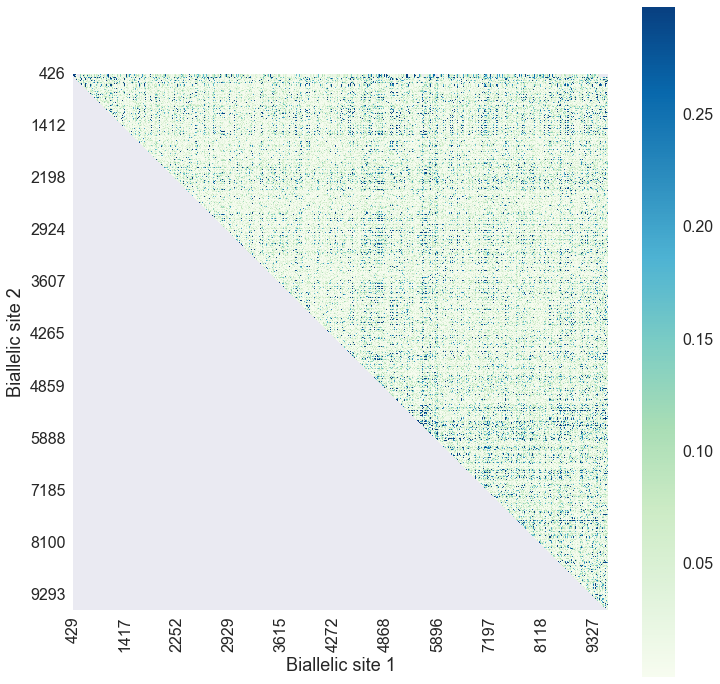

In [19]:
fig,ax = plt.subplots(figsize=(12,12), nrows=1, ncols=1)
heatmap = sns.heatmap(results, cmap = plt.cm.GnBu, square = True, 
                      xticklabels=200, yticklabels=200, robust=True, annot=False)

for label in ax.get_yticklabels() + ax.get_xticklabels():
        label.set_size(13)

cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=16)
for label in ax.get_yticklabels() + ax.get_xticklabels():
        label.set_size(16)

ax.set_xlabel('Biallelic site 1', fontsize=18)
ax.set_ylabel('Biallelic site 2', fontsize=18)
# plt.tight_layout()
plt.yticks(rotation=0)
plt.xticks(rotation=90) 
# plt.tight_layout(pad=1)
plt.show()
# plt.savefig('r_squared.png')

### Figure S1: Extensive divergence makes sitewise measures of genetic linkage ineffective  
For pairs of biallelic sites (ignoring rare variants), R^2 was used to estimate how strongly the allele in one site predicts the allele in the second site, with values of 0 indicating no linkage and 1 indicating perfect linkage. The mean value of R^2 was 0.044, indicating very low levels of linkage overall.